# Imports

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords

import tensorflow_datasets as tfds

In [7]:
train_data, val_data = tfds.load(name='movie_rationales', split=['train', 'validation'], batch_size=-1)

In [58]:
train_data['evidences']

<tf.Tensor: shape=(1600, 32), dtype=string, numpy=
array([[b'stale actioners',
        b'unworthy of the most gullible audience member',
        b'everything begins going downhill . . . quickly .', ..., b'',
        b'', b''],
       [b'the stroke of pure genius', b'it is a worthy companion piece',
        b'retains some of the best core elements', ..., b'', b'', b''],
       [b'unoriginal and unthrilling', b'a half - assed effort',
        b"it 's just such a cliche in and of itself", ..., b'', b'', b''],
       ...,
       [b'played with abandon , conviction and sensitivity all at once',
        b'this is a great picture , no doubt , and i love it personally . because it is moving , funny',
        b'but i like it and admire it because it comes from a fine american tradition',
        ..., b'', b'', b''],
       [b'the ridiculous story', b'knucklehead',
        b'there is no camp value in the film , no interesting main characters , no invigorating action scenes , no reason at all to 

In [85]:
train_ = ['review', 'evidences']

train_text = tfds.as_numpy(train_data[train_[0]])
train_labels = tfds.as_numpy(train_data['label'])

val_text = tfds.as_numpy(val_data[train_[0]])
val_labels = tfds.as_numpy(val_data['label'])

train_text_list = [str(x) for x in train_text]
val_text_list = [str(x) for x in val_text]

In [86]:
def calc_max_length(text_list):
    sentence_len = []
    for sentence in text_list:
        sentence_len.append(len([word for word in sentence.split()]))
    return max(sentence_len)

calc_max_length(train_text_list)

2721

In [87]:
np.unique(train_labels)

array([0, 1])

# Preprocess and Pad

In [88]:
# Parameters for padding and OOV tokens
vocab_size = 10000
max_length = calc_max_length(train_text_list)
trunc_type='post'
padding_type='post'
oov_token = "<OOV>"

In [89]:
tokenizer = Tokenizer(num_words=vocab_size,
                     oov_token=oov_token)

tokenizer.fit_on_texts(train_text_list)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_text_list)
val_sequences = tokenizer.texts_to_sequences(val_text_list)

train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type)
val_padded = pad_sequences(val_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type)


# Model and Callbacks

In [92]:
embedding_dim = 16

class MyEarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.9\
        and logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.85:
            self.stop_training = True

es_1 =MyEarlyStopping()

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(train_padded,
                   train_labels,
                   epochs=50,
                   batch_size=32,
                   validation_data=(val_padded, val_labels),
                   callbacks=[es_1])

Epoch 1/50
50/50 [==============================] - 88s 2s/step - loss: 0.6936 - accuracy: 0.4906 - val_loss: 0.6932 - val_accuracy: 0.5150
Epoch 2/50
50/50 [==============================] - 97s 2s/step - loss: 0.6921 - accuracy: 0.5225 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 3/50
50/50 [==============================] - 97s 2s/step - loss: 0.6274 - accuracy: 0.6712 - val_loss: 0.6241 - val_accuracy: 0.6300
Epoch 4/50
50/50 [==============================] - 99s 2s/step - loss: 0.3315 - accuracy: 0.8719 - val_loss: 0.7927 - val_accuracy: 0.6750
Epoch 5/50
50/50 [==============================] - 102s 2s/step - loss: 0.1282 - accuracy: 0.9581 - val_loss: 0.9365 - val_accuracy: 0.6500
Epoch 6/50
50/50 [==============================] - 102s 2s/step - loss: 0.0331 - accuracy: 0.9919 - val_loss: 1.4612 - val_accuracy: 0.6450
Epoch 7/50
50/50 [==============================] - 102s 2s/step - loss: 0.0128 - accuracy: 0.9962 - val_loss: 1.7384 - val_accuracy: 0.6550
Epoch 8/50
50/50 

KeyboardInterrupt: 

In [93]:
def learning_curves(history):
    '''Creates a n * max(m, 3) set of plots of learning curves for each metric logged. Requires a validation set.'''
    # Put metrics from history.history in a data frame
    metrics = pd.DataFrame(dict(history.history))
    epochs = np.arange(1, metrics.shape[0] + 1, 1)

    # Determine size of plot based
    if len(metrics.columns) > 3:
        n_rows = int((len(metrics.columns) / 2 - 1) // 3 + 1)
        n_col = 3
    n_rows = 1
    n_cols = int(len(metrics.columns) / 2)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))

    # Determine pairs from dictionary
    pairs = []
    for i, metric in enumerate(metrics.columns, 1):
        if i <= metrics.shape[1] / 2:
            pairs.append([column for column in metrics.columns if metric in column])

    # Plot pairs
    for i, pair in enumerate(pairs):
        axes[i].plot(epochs, metrics[pair[0]], label=pair[0])
        axes[i].plot(epochs, metrics[pair[1]], label=pair[1])
        axes[i].set_title(f'Training and Validation {pair[0].title()}')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(pair[0].title())
        axes[i].legend()
    
    fig.suptitle('Learning Curves', fontsize=20)
    plt.show()

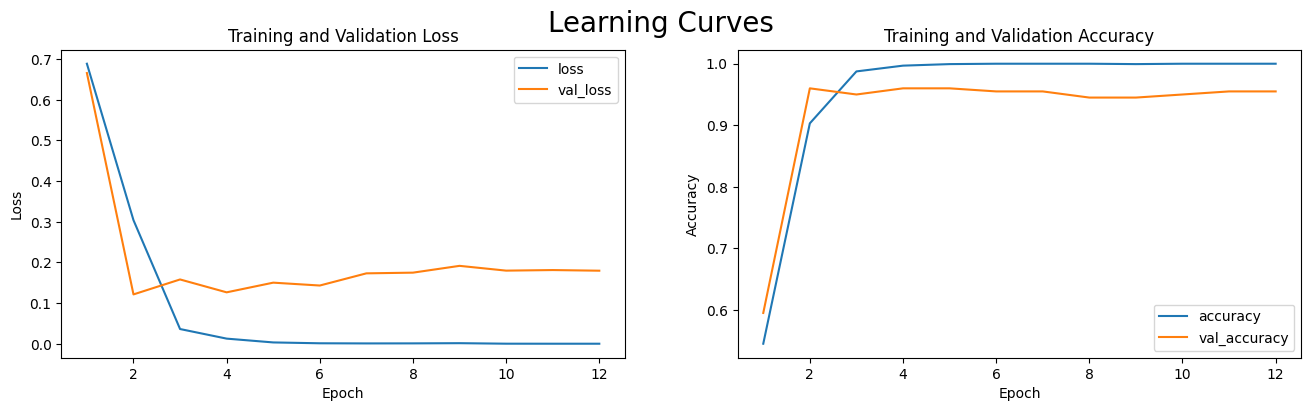

In [94]:
learning_curves(history)

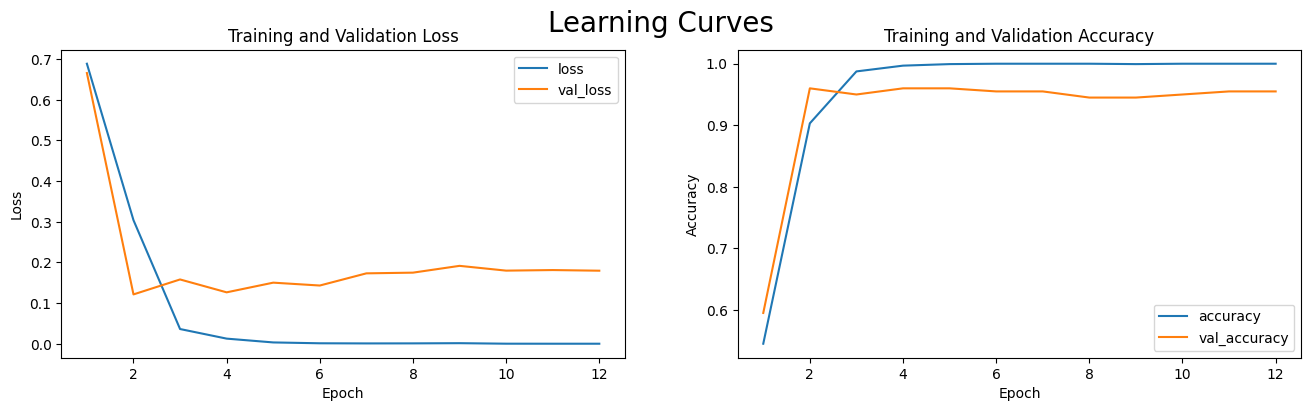

In [80]:
learning_curves(history)